# Video generation with ZeroScope and OpenVINO

The ZeroScope model is a free and open-source text-to-video model that can generate realistic and engaging videos from text descriptions. It is based on the Modelscope model, but it has been improved to produce higher-quality videos with a 16:9 aspect ratio and no Shutterstock watermark. The ZeroScope model is available in two versions: Zeroscope_v2 576w, which is optimized for rapid content creation at a resolution of 576x320 pixels, and Zeroscope_v2 XL, which upscales videos to a high-definition resolution of 1024x576.

The ZeroScope model is trained on a dataset of over 9,000 videos and 29,000 tagged frames. It uses a diffusion model to generate videos, which means that it starts with a random noise image and gradually adds detail to it until it matches the text description. The ZeroScope model is still under development, but it has already been used to create some impressive videos. For example, it has been used to create videos of people dancing, playing sports, and even driving cars.

The ZeroScope model is a powerful tool that can be used to create various videos, from simple animations to complex scenes. It is still under development, but it has the potential to revolutionize the way we create and consume video content.

Both versions of the ZeroScope model are available on Hugging Face:
 - [Zeroscope_v2 576w](https://huggingface.co/cerspense/zeroscope_v2_576w)
 - [Zeroscope_v2 XL](https://huggingface.co/cerspense/zeroscope_v2_XL)

We will use the first one.

Table of content:
- 1. [Install and import required packages](#Install-and-import-required-packages)
- 2. [Load the model](#Load-the-model)
- 3. [Convert the model](#Convert-the-model)
    - 3.1. [Define the conversion function](#Define-the-conversion-function)
    - 3.2. [UNet](#UNet)
    - 3.3. [VAE](#VAE)
    - 3.4. [Text encoder](#Text-encoder)
- 4. [Build a pipeline](#Build-a-pipeline)
- 5. [Inference with OpenVINO](#Inference-with-OpenVINO)
    - 5.1. [Select inference device](#Select-inference-device)
    - 5.2. [Define a prompt](#Define-a-prompt)
    - 5.3. [Video generation](#Video-generation)

## Install and import required packages

To work with text-to-video synthesis model, we will use Hugging Face's [Diffusers](https://github.com/huggingface/diffusers) library. It provides already pretrained model from `cerspense`.

In [1]:
!pip install -q "diffusers[torch]>=0.15.0" transformers "openvino==2023.1.0.dev20230728" imageio[ffmpeg] numpy

In [2]:
import gc
from pathlib import Path
from typing import Optional, Union, List, Callable, Dict, Any
import base64

import diffusers
import transformers
import numpy as np
import imageio
import IPython
import ipywidgets as widgets
import torch
import PIL

import openvino
from openvino.tools import mo

2023-08-15 18:32:06.865469: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 18:32:07.267398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 18:32:08.586176: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 18:32:08.589406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 18:32:11.076063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Load the model

The model is loaded from Huggingface using `.from_pretrained` method of `diffusers.DiffusionPipeline`.

In [3]:
pipe = diffusers.DiffusionPipeline.from_pretrained('cerspense/zeroscope_v2_576w')

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Convert the model

The architecture for generating videos from text comprises three distinct sub-networks: one for extracting text features, another for translating text features into the video latent space using a diffusion model, and a final one for mapping the video latent space to the visual space. The collective parameters of the entire model amount to approximately 1.7 billion. It's capable of processing English input. The diffusion model is built upon the Unet3D framework and achieves video generation by iteratively denoising a starting point of pure Gaussian noise video.

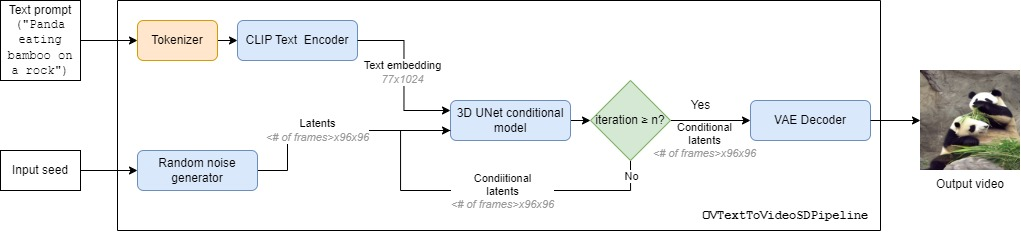

### Define the conversion function

Model components are PyTorch modules, that can be converted with `openvino.convert` function directly. We also use `openvino.save` function to serialize the result of conversion.

In [4]:
def convert(model: torch.nn.Module, xml_path: str, **convert_kwargs) -> Path:
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        converted_model = openvino.convert_model(model, **convert_kwargs)
        openvino.save_model(converted_model, xml_path)
    return xml_path

In [5]:
core = openvino.Core()

In [6]:
sample_size = pipe.unet.sample_size

### UNet

In [7]:
unet_xml_path = convert(
        pipe.unet,
        "models/unet.xml",
        example_input={
            "sample": torch.randn(2, 4, 16, sample_size, sample_size),
            "timestep": torch.tensor(1),
            "encoder_hidden_states": torch.randn(2, 77, sample_size * sample_size),
        },
    )
del pipe.unet
gc.collect()

40

### VAE

Variational autoencoder (VAE) uses UNet output to decode latents to visual representations. Decoding is done in 2 steps: mapping from quantized embedding space to embedding space (using convolutional layer) and passing the result to decoder.

In [8]:
vae_decoder_xml_path = convert(pipe.vae.decoder, "models/vae/decoder.xml", example_input=torch.randn(16, 4, sample_size, sample_size))
del pipe.vae.decoder
gc.collect()

0

In [9]:
vae_post_quant_conv_xml_path = convert(
        pipe.vae.post_quant_conv, "models/vae/post_quant_conv.xml", example_input=torch.randn(16, 4, sample_size, sample_size)
    )
del pipe.vae.post_quant_conv
gc.collect()

0

### Text encoder

Text encoder is used to encode the input prompt to tensor. Default tensor length is 77.

In [10]:
text_encoder_xml = convert(pipe.text_encoder, "models/text_encoder.xml", example_input=torch.ones(1, 77, dtype=torch.int64))
del pipe.text_encoder
gc.collect()

0

## Build a pipeline

In [11]:
def tensor2vid(video: torch.Tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> List[np.ndarray]:
    # This code is copied from https://github.com/modelscope/modelscope/blob/1509fdb973e5871f37148a4b5e5964cafd43e64d/modelscope/pipelines/multi_modal/text_to_video_synthesis_pipeline.py#L78
    # reshape to ncfhw
    mean = torch.tensor(mean, device=video.device).reshape(1, -1, 1, 1, 1)
    std = torch.tensor(std, device=video.device).reshape(1, -1, 1, 1, 1)
    # unnormalize back to [0,1]
    video = video.mul_(std).add_(mean)
    video.clamp_(0, 1)
    # prepare the final outputs
    i, c, f, h, w = video.shape
    images = video.permute(2, 3, 0, 4, 1).reshape(
        f, h, i * w, c
    )  # 1st (frames, h, batch_size, w, c) 2nd (frames, h, batch_size * w, c)
    images = images.unbind(dim=0)  # prepare a list of indvidual (consecutive frames)
    images = [(image.cpu().numpy() * 255).astype("uint8") for image in images]  # f h w c
    return images

In [12]:
class OVTextToVideoSDPipeline(diffusers.DiffusionPipeline):
    def __init__(
            self,
            vae_decoder: openvino.CompiledModel,
            post_quant_conv: openvino.CompiledModel,
            text_encoder: openvino.CompiledModel,
            tokenizer: transformers.CLIPTokenizer,
            unet: openvino.CompiledModel,
            scheduler: diffusers.schedulers.DDIMScheduler,
            
        ):
            super().__init__()

            self.vae_decoder = vae_decoder
            self.post_quant_conv = post_quant_conv
            self.text_encoder = text_encoder
            self.tokenizer = tokenizer
            self.unet = unet
            self.scheduler = scheduler
            self.vae_scale_factor = 8
            self.unet_sample_size = sample_size
            self.unet_in_channels = 4
            
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_frames: int = 16,
        num_inference_steps: int = 50,
        guidance_scale: float = 9.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "np",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the video generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated video.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated video.
            num_frames (`int`, *optional*, defaults to 16):
                The number of video frames that are generated. Defaults to 16 frames which at 8 frames per seconds
                amounts to 2 seconds of video.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality videos at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate videos that are closely linked to the text `prompt`,
                usually at the expense of lower video quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the video generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for video
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`. Latents should be of shape
                `(batch_size, num_channel, num_frames, height, width)`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            output_type (`str`, *optional*, defaults to `"np"`):
                The output format of the generate video. Choose between `torch.FloatTensor` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.TextToVideoSDPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.TextToVideoSDPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.TextToVideoSDPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated frames.
        """
        # 0. Default height and width to unet
        height = height or self.unet_sample_size * self.vae_scale_factor
        width = width or self.unet_sample_size * self.vae_scale_factor

        num_images_per_prompt = 1

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet_in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            num_frames,
            height,
            width,
            prompt_embeds.dtype,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = {"generator": generator, "eta": eta}

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet({"sample": latent_model_input, "timestep": t, "encoder_hidden_states": prompt_embeds})[0]
                noise_pred = torch.tensor(noise_pred)

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # reshape latents
                bsz, channel, frames, width, height = latents.shape
                latents = latents.permute(0, 2, 1, 3, 4).reshape(bsz * frames, channel, width, height)
                noise_pred = noise_pred.permute(0, 2, 1, 3, 4).reshape(bsz * frames, channel, width, height)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # reshape latents back
                latents = latents[None, :].reshape(bsz, frames, channel, width, height).permute(0, 2, 1, 3, 4)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        video_tensor = self.decode_latents(latents)

        if output_type == "pt":
            video = video_tensor
        else:
            video = tensor2vid(video_tensor)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (video,)

        return {"frames": video}
    
# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(
        self,
        prompt,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
        """
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            # textual inversion: procecss multi-vector tokens if necessary
            if isinstance(self, diffusers.loaders.TextualInversionLoaderMixin):
                prompt = self.maybe_convert_prompt(prompt, self.tokenizer)

            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                print(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            
            prompt_embeds = self.text_encoder(text_input_ids)
            prompt_embeds = prompt_embeds[0]
            prompt_embeds = torch.tensor(prompt_embeds)
            

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            # textual inversion: procecss multi-vector tokens if necessary
            if isinstance(self, diffusers.loaders.TextualInversionLoaderMixin):
                uncond_tokens = self.maybe_convert_prompt(uncond_tokens, self.tokenizer)

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            negative_prompt_embeds = self.text_encoder(uncond_input.input_ids)
            negative_prompt_embeds = negative_prompt_embeds[0]
            negative_prompt_embeds = torch.tensor(negative_prompt_embeds)

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        return prompt_embeds
    
    
    def prepare_latents(
        self, batch_size, num_channels_latents, num_frames, height, width, dtype, generator, latents=None
    ):
        shape = (
            batch_size,
            num_channels_latents,
            num_frames,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = diffusers.utils.randn_tensor(shape, generator=generator, dtype=dtype)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents
    
    def check_inputs(
        self,
        prompt,
        height,
        width,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )
                
    def decode_latents(self, latents):
        scale_factor = 0.18215
        latents = 1 / scale_factor * latents

        batch_size, channels, num_frames, height, width = latents.shape
        latents = latents.permute(0, 2, 1, 3, 4).reshape(batch_size * num_frames, channels, height, width)
        z = self.post_quant_conv(latents)[0]
        image = self.vae_decoder(z)[0]
        image = torch.tensor(image)
        video = (
            image[None, :]
            .reshape(
                (
                    batch_size,
                    num_frames,
                    -1,
                )
                + image.shape[2:]
            )
            .permute(0, 2, 1, 3, 4)
        )
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        video = video.float()
        return video

## Inference with OpenVINO

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [13]:
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [16]:
%%time
ov_unet = core.compile_model(unet_xml_path, device_name=device.value)

CPU times: user 2min 4s, sys: 425 ms, total: 2min 5s
Wall time: 2min 3s


In [17]:
%%time
ov_vae_decoder = core.compile_model(vae_decoder_xml_path, device_name=device.value)

CPU times: user 421 ms, sys: 280 ms, total: 701 ms
Wall time: 967 ms


In [18]:
%%time
ov_vae_post_quant_conv = core.compile_model(vae_post_quant_conv_xml_path, device_name=device.value)

CPU times: user 28.7 ms, sys: 260 µs, total: 29 ms
Wall time: 84.9 ms


In [19]:
%%time
ov_text_encoder = core.compile_model(text_encoder_xml, device_name=device.value)

CPU times: user 1.41 s, sys: 278 ms, total: 1.68 s
Wall time: 3.4 s


Here we replace the pipeline parts with versions converted to OpenVINO IR and compiled to specific device. Note that we use original pipeline tokenizer and scheduler.

In [20]:
ov_pipe = OVTextToVideoSDPipeline(ov_vae_decoder, ov_vae_post_quant_conv, ov_text_encoder, pipe.tokenizer, ov_unet, pipe.scheduler)
del pipe
gc.collect()

1583

### Define a prompt

In [21]:
prompt = "Panda eating bamboo on a rock"

Let's generate a video for our prompt! For full list of arguments, see `__call__` function definition of `OVTextToVideoSDPipeline` class in [Build a pipeline](#Build-a-pipeline) section.

### Video generation

In [22]:
frames = ov_pipe(prompt, num_inference_steps=25)['frames']

  0%|          | 0/25 [00:00<?, ?it/s]

Our video is ready! Let's check it out!


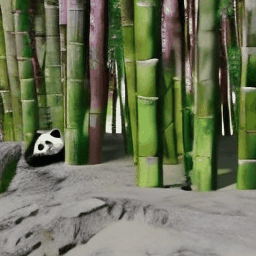

In [23]:
images = [PIL.Image.fromarray(frame) for frame in frames]
images[0].save("output.gif", save_all=True, append_images=images[1:], duration=125, loop=0)
with open("output.gif", "rb") as gif_file:
    b64 = f'data:image/gif;base64,{base64.b64encode(gif_file.read()).decode()}'
IPython.display.HTML(f"<img src=\"{b64}\" />")